In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.integrate import cumulative_trapezoid
import time

# ==============================================================================
# --- 1. Setup: Constants & Thermodynamic Functions ---
# ==============================================================================

print("--- 1. Initializing constants and functions ---")

# --- Physical constants ---
g = constants.g
cpd = 1005.7
Rd  = 287.05
Rv  = 461.5
epsilon = Rd / Rv
Lv = 2.501e6

# --- Thermodynamic utilities (same as Fig. 4) ---
def saturation_vapor_pressure(T):
    T_c = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_c)/(T_c + 243.5))
    return es_hPa * 100.0  # Pa

def saturation_specific_humidity(p, T):
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denom = p - (1.0 - epsilon) * es
    qs = np.divide(epsilon * es, denom, out=np.full_like(p,1e-9), where=denom>0)
    return np.maximum(qs,1e-9)

def dqs_dT(p, T, dT=0.01):
    return (saturation_specific_humidity(p, T + dT)
          - saturation_specific_humidity(p, T - dT)) / (2*dT)

def dqs_dp(p, T, dp=10.0):
    return (saturation_specific_humidity(p + dp, T)
          - saturation_specific_humidity(p - dp, T)) / (2*dp)

def d2qs_dT2(p, T, dT=0.01):
    qs_p = saturation_specific_humidity(p, T + dT)
    qs_0 = saturation_specific_humidity(p, T)
    qs_m = saturation_specific_humidity(p, T - dT)
    return (qs_p - 2*qs_0 + qs_m) / (dT**2)

def d2qs_dTdp(p, T, dT=0.01, dp=10.0):
    dT_plus  = dqs_dT(p + dp, T, dT)
    dT_minus = dqs_dT(p - dp, T, dT)
    return (dT_plus - dT_minus) / (2*dp)

def virtual_temperature(T, p):
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1 + (1/epsilon - 1)*qs)
    return np.maximum(Tv,10.0)

def calculate_mse(T, p, z):
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv * qs

def calculate_profile_with_rootfinder(T_surf, p_surf, p_grid):
    n = len(p_grid)
    T_prof = np.full(n, np.nan); z_prof = np.full(n, np.nan)
    T_prof[0], z_prof[0] = T_surf, 0.0
    mse0 = calculate_mse(T_surf, p_grid[0], 0.0)
    for i in range(n-1):
        T_cur, p_cur, z_cur = T_prof[i], p_grid[i], z_prof[i]
        p_next = p_grid[i+1]
        if np.isnan(T_cur) or p_cur <= 0: break
        Tv = virtual_temperature(T_cur, p_cur)
        dz = - (Rd * Tv / p_cur) / g * (p_next - p_cur)
        z_next = z_cur + dz
        def resid(Tg): return calculate_mse(Tg, p_next, z_next) - mse0
        try:
            br = [150.0, T_cur + 5.0]
            if resid(br[0]) * resid(br[1]) > 0: break
            sol = root_scalar(resid, bracket=br, method='brentq', xtol=1e-3)
            if sol.converged:
                T_prof[i+1], z_prof[i+1] = sol.root, z_next
            else: break
        except: break
    return T_prof

# ==============================================================================
# --- 2. 2D Calculation (p vs. T_s) ---
# ==============================================================================

print("--- 2. Starting 2D calculation (p vs. T_s) ---")
t0 = time.time()

# --- Grid & storage ---
T_surf_vals = np.arange(270, 320.1, 0.5) 
p_s, p_top, dp = 100000.0, 10000.0, -50.0
p_grid = np.arange(p_s, p_top + dp, dp)
n_p, n_t = len(p_grid), len(T_surf_vals)

# --- Storage for 2D fields ---
cL_grid = np.full((n_p, n_t), np.nan)
dGamma_m_dT_grid = np.full((n_p, n_t), np.nan)
dGamma_m_dTs_grid = np.full((n_p, n_t), np.nan)
warming_anomaly_grid = np.full((n_p, n_t), np.nan) 

for j, Ts in enumerate(T_surf_vals):
    if j % 20 == 0:
        print(f"  Calculating for T_s = {Ts:.1f} K...")
    
    Tprof = calculate_profile_with_rootfinder(Ts, p_s, p_grid)
    if np.isnan(Tprof[-1]):
        continue
    
    cL_vals = Lv * dqs_dT(p_grid, Tprof)
    D = cpd + cL_vals
    dD_dT = Lv * d2qs_dT2(p_grid, Tprof)
    
    alpha_d = Rd * Tprof / p_grid
    alpha_L = -Lv * dqs_dp(p_grid, Tprof)
    N = alpha_d + alpha_L
    
    d_alpha_d_dT = Rd / p_grid
    d_alpha_L_dT = -Lv * d2qs_dTdp(p_grid, Tprof)
    dN_dT = d_alpha_d_dT + d_alpha_L_dT
    
    Term_A = (1.0 / D) * dN_dT
    Term_B = - (N / (D**2)) * dD_dT
    
    dGamma_m_dT_profile = Term_A + Term_B
    
    integral_term = cumulative_trapezoid(dGamma_m_dT_profile, x=p_grid, initial=0.0)
    exp_term = np.exp(integral_term)
    dGamma_m_dTs_profile = dGamma_m_dT_profile * exp_term
    
    integral_W = cumulative_trapezoid(dGamma_m_dTs_profile, x=p_grid, initial=0.0)
    W_anomaly_profile = integral_W
    
    cL_grid[:, j] = cL_vals
    dGamma_m_dT_grid[:, j] = dGamma_m_dT_profile
    dGamma_m_dTs_grid[:, j] = dGamma_m_dTs_profile
    warming_anomaly_grid[:, j] = W_anomaly_profile

print(f"2D calculation done in {time.time() - t0:.1f}s")

# ==============================================================================
# --- 3. Find Extrema T_s at each Pressure Level (INTERPOLATED) ---
# ==============================================================================

print("--- 3. Finding extrema T_s at each pressure level (interpolated) ---")
t0 = time.time()

# --- Pre-calculate T_s gradients for finding extrema ---
dT_s = T_surf_vals[1] - T_surf_vals[0]
grad_dGamma_m_dT_grid = np.gradient(dGamma_m_dT_grid, dT_s, axis=1)
grad_dGamma_m_dTs_grid = np.gradient(dGamma_m_dTs_grid, dT_s, axis=1)
grad_warming_anomaly_grid = np.gradient(warming_anomaly_grid, dT_s, axis=1)

p_grid_hpa = p_grid / 100.0 # Dense y-axis for plotting
predicted_Ts_peak = np.full(n_p, np.nan)
actual_Ts_min_dT = np.full(n_p, np.nan)
actual_Ts_min_dTs = np.full(n_p, np.nan)
actual_Ts_max_W_anomaly = np.full(n_p, np.nan)

# --- Helper function for stable root interpolation ---
def find_interpolated_root(y_slice, x_vals, y_slice_for_guess=None, guess_mode='min'):
    """
    Finds the interpolated root of y_slice.
    If multiple roots, uses y_slice_for_guess to pick the one
    closest to the discrete min/max.
    """
    if np.all(np.isnan(y_slice)):
        return np.nan

    # Find all sign changes
    sign_changes = np.where((y_slice[:-1] * y_slice[1:]) < 0)[0]
    
    # Filter for valid crossings
    k_all = []
    for k in sign_changes:
        if np.isfinite(y_slice[k]) and np.isfinite(y_slice[k+1]):
            k_all.append(k)
            
    if not k_all:
        return np.nan

    # Interpolate all candidate roots
    T_candidates = []
    for k in k_all:
        T0, T1 = x_vals[k], x_vals[k+1]
        y0, y1 = y_slice[k], y_slice[k+1]
        if y1 == y0: continue
        T_root = T0 - y0 * (T1 - T0) / (y1 - y0)
        T_candidates.append(T_root)

    if not T_candidates:
        return np.nan
        
    if len(T_candidates) == 1:
        return T_candidates[0]

    # If multiple roots, use the discrete min/max as a guess
    if y_slice_for_guess is None:
        y_slice_for_guess = y_slice
        
    if guess_mode == 'min':
        j_guess = np.nanargmin(y_slice_for_guess)
    elif guess_mode == 'max':
        j_guess = np.nanargmax(y_slice_for_guess)
    else: # 'abs_min'
        j_guess = np.nanargmin(np.abs(y_slice_for_guess))
        
    T_guess = x_vals[j_guess]
    
    # Return the candidate root closest to the discrete guess
    T_best = min(T_candidates, key=lambda T: abs(T - T_guess))
    return T_best

# Loop over every pressure level 'i' in the dense grid
for i in range(n_p):
    
    # --- 1. Find T_s for c_L = c_pd ---
    y_slice = cL_grid[i, :] - cpd
    predicted_Ts_peak[i] = find_interpolated_root(
        y_slice, T_surf_vals, guess_mode='abs_min'
    )

    # --- 2. Find T_s for min(dGamma_m/dT) ---
    grad_slice = grad_dGamma_m_dT_grid[i, :]
    # Find root of gradient (neg->pos sign change)
    actual_Ts_min_dT[i] = find_interpolated_root(
        grad_slice, T_surf_vals, 
        y_slice_for_guess=dGamma_m_dT_grid[i, :], 
        guess_mode='min'
    )
        
    # --- 3. Find T_s for min(dGamma_m/dTs) ---
    grad_slice = grad_dGamma_m_dTs_grid[i, :]
    # Find root of gradient (neg->pos sign change)
    actual_Ts_min_dTs[i] = find_interpolated_root(
        grad_slice, T_surf_vals,
        y_slice_for_guess=dGamma_m_dTs_grid[i, :],
        guess_mode='min'
    )

    # --- 4. Find T_s for max(Warming Anomaly) ---
    grad_slice = grad_warming_anomaly_grid[i, :]
    # Find root of gradient (pos->neg sign change)
    actual_Ts_max_W_anomaly[i] = find_interpolated_root(
        grad_slice, T_surf_vals,
        y_slice_for_guess=warming_anomaly_grid[i, :],
        guess_mode='max'
    )

print(f"Extrema finding done in {time.time() - t0:.1f}s")

# --- Post-processing fix ---
# Set 1000 hPa point (index 0) for warming anomaly to NaN
# p_grid[0] is 100000.0 Pa
actual_Ts_max_W_anomaly[0] = np.nan



--- 1. Initializing constants and functions ---
--- 2. Starting 2D calculation (p vs. T_s) ---
  Calculating for T_s = 270.0 K...
  Calculating for T_s = 280.0 K...
  Calculating for T_s = 290.0 K...
  Calculating for T_s = 300.0 K...
  Calculating for T_s = 310.0 K...
  Calculating for T_s = 320.0 K...
2D calculation done in 6.5s
--- 3. Finding extrema T_s at each pressure level (interpolated) ---
Extrema finding done in 0.0s


--- 4. Generating Figure 5 ---


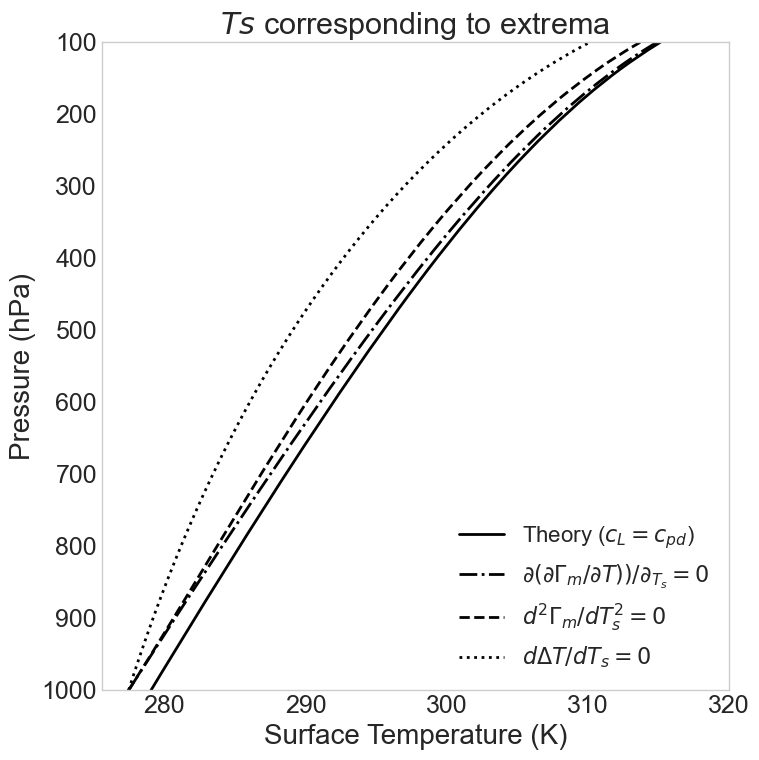

Figure 5 saved as fig-5.png


In [58]:
# ==============================================================================
# --- 4. Plotting (Using your provided manual updates) ---
# ==============================================================================

print("--- 4. Generating Figure 5 ---")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size':20,
    'axes.titlesize':22,
    'axes.labelsize':20,
    'xtick.labelsize':18,
    'ytick.labelsize':18,
    'legend.fontsize':16 
})

fig, ax = plt.subplots(figsize=(8, 8))

# --- Plot 1: Predicted T_s ---
# We now plot with markers turned off ('-') to show the smooth line
ax.plot(predicted_Ts_peak, p_grid_hpa, '-', color='black', lw=2,
        label=r'Theory ($c_L = c_{pd}$)')

# --- Plot 2: Actual T_s_min (local T derivative) ---
ax.plot(actual_Ts_min_dT, p_grid_hpa, '-.', color='black', lw=2,
        label=r'$\partial(\partial\Gamma_m/\partial T))/\partial_{T_s} = 0$')

# --- Plot 3: Actual T_s_min (T_s derivative) ---
ax.plot(actual_Ts_min_dTs, p_grid_hpa, '--', color='black', lw=2,
        label=r'$d^2\Gamma_m/dT_s^2=0$')

# --- Plot 4: Actual T_s_max (Warming Anomaly) ---
ax.plot(actual_Ts_max_W_anomaly, p_grid_hpa, ':', color='black', lw=2,
        label=r'$d\Delta T/dT_s = 0$')

# Formatting
ax.set_xlabel('Surface Temperature (K)')
ax.set_ylabel('Pressure (hPa)')
ax.invert_yaxis()
ax.set_xlim(right=320)
ax.set_ylim(1000, 100)
# Set sparse ticks even though the plot is dense
p_levels_hpa = np.arange(100, 1001, 100)
ax.set_yticks(p_levels_hpa)
ax.set_title(r'$Ts$ corresponding to extrema')
ax.legend(loc='lower right')
ax.grid(False)

plt.tight_layout()
plt.savefig("fig-5.png", dpi=600, bbox_inches='tight')
plt.show()
print("Figure 5 saved as fig-5.png")

In [59]:
print(np.max(predicted_Ts_peak - actual_Ts_min_dT))
print(np.max(predicted_Ts_peak - actual_Ts_min_dTs))
print(np.nanmax(predicted_Ts_peak - actual_Ts_max_W_anomaly))

1.5842726793194402
2.014064513512949
6.620359469162111


In [60]:
print(p_grid_hpa[np.argmax(predicted_Ts_peak - actual_Ts_min_dT)])
print(p_grid_hpa[np.argmax(predicted_Ts_peak - actual_Ts_min_dTs)])
print(p_grid_hpa[np.nanargmax(predicted_Ts_peak - actual_Ts_max_W_anomaly)])

1000.0
419.5
382.0
